<a href="https://colab.research.google.com/github/vijaygwu/IntroToDeepLearning/blob/main/Class_1_LatentSpace_PyTorch_LeakyRelu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The provided code defines and utilizes an Autoencoder neural network for the MNIST dataset. Here's a detailed explanation:

- **Autoencoder Class**: This class creates a neural network with encoder and decoder components. The encoder compresses the input image into a lower-dimensional latent space, and the decoder reconstructs the image from this latent space. The network is structured to flatten and process 28x28 grayscale MNIST images.

- **Data Loading**: Utilizes PyTorch's DataLoader to efficiently load the MNIST dataset, applying transformations to normalize the images.

- **Training Loop**: Iterates over the training dataset, feeding batches of images through the model, calculating the reconstruction loss, and updating the model's weights to minimize this loss, effectively learning to compress and reconstruct the input images.

- **Visualization**: After training, the script visualizes a batch of original images and their reconstructions from the autoencoder. It also prints the latent space representations, showcasing what the model has learned to encode.

- **Utility Functions**: Includes `imshow` for displaying tensors as images. It unnormalizes the data and uses Matplotlib to plot them.

This script encapsulates the end-to-end process of training an autoencoder on the MNIST dataset, visualizing the results, and examining the learned latent space.

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
from torch.cuda.amp import GradScaler, autocast

 The `Autoencoder` class inherits from `nn.Module`, a base class for all neural network modules in PyTorch. Here's a breakdown of the code and its functionality:

### Initialization Method (`__init__`)
- **Parameters**: The `__init__` method accepts a single parameter `encoding_dim`, which specifies the size of the latent space where the input data is compressed.
- **Encoder**: The encoder part of the autoencoder is designed to compress the input data (in this case, an image) into a lower-dimensional representation called the latent space. It consists of a sequence of layers:
  - `nn.Linear(28 * 28, 128)`: This layer flattens the input image (assumed to be 28x28 pixels, typical for MNIST dataset images) into a one-dimensional array and performs a linear transformation to reduce its dimension to 128.
  - `nn.ReLU(True)`: A Rectified Linear Unit (ReLU) activation function is applied to introduce non-linearity, helping the model learn complex patterns.
  - Another `nn.Linear(128, encoding_dim)`: Further reduces the dimension from 128 to the specified `encoding_dim`.
  - Another `nn.ReLU(True)`: Another ReLU activation for non-linearity.
- **Decoder**: The decoder part reconstructs the original input data from the compressed representation. It mirrors the encoder structure but in reverse, aiming to expand the compressed data back to its original shape:
  - `nn.Linear(encoding_dim, 128)`: Expands the compressed data from `encoding_dim` back to 128.
  - `nn.ReLU(True)`: Applies ReLU activation.
  - `nn.Linear(128, 28 * 28)`: Transforms the data from 128 back to the flattened image size of 784 (28x28).
  -  'nn.LeakyReLU()': Applies the Leaky ReLU activation function

### Forward Method (`forward`)
- **Parameter**: The `forward` method defines how the input `x` flows through the network.
- **Process**:
  - `x.view(-1, 28*28)`: First, the input `x` is reshaped into a one-dimensional array (flattened) if not already done.
  - `self.encoder(x)`: The flattened `x` is then passed through the encoder.
  - `self.decoder(x)`: The output from the encoder, which is the compressed representation, is fed into the decoder.
- **Output**: The final output is reshaped back to the original image dimensions (`-1, 1, 28, 28`), where `-1` is a placeholder that automatically adjusts based on the batch size.


In [15]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder: compresses the image into a lower-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Flatten the image and then linearly transform it
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(128, encoding_dim),  # Linear transformation to the encoding dimension
            nn.ReLU(True)  # Non-linear activation function
        )
        # Decoder: reconstructs the image from the latent space
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),  # Linearly transforms the encoding
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(128, 28 * 28),  # Transforms back to original image shape
            nn.LeakyReLU() # Leaky ReLU activation function
        )

    def forward(self, x):
        x = self.encoder(x.view(-1, 28*28))  # Encode the input image
        x = self.decoder(x)  # Decode the encoded image
        return x.view(-1, 1, 28, 28)  # Reshape to the original image dimensions

In [16]:

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()  # Convert the tensor to a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Reshape and display the image
    plt.show()

## Transform

Transform is a crucial preprocessing step in many PyTorch workflows, ensuring that images are in the correct format and scale for efficient training of neural networks.



### What This Code Does:

1. **`transforms.Compose([])`**:
   - **Purpose**: This function is used to chain together multiple image transformations. The transformations are applied in the order they are listed inside the square brackets.
   - **Example Use Case**: If you need to apply several preprocessing steps to your images (e.g., resizing, converting to a tensor, normalizing), you can group them together using `transforms.Compose`.

2. **`transforms.ToTensor()`**:
   - **Purpose**: Converts an image to a PyTorch tensor.
   - **Detailed Explanation**:
     - **Input**: This function expects the input to be a PIL (Python Imaging Library) image or a NumPy `ndarray`.
     - **Conversion**: It converts the input image into a PyTorch tensor. If the image is a PIL image, it is typically in the format `(H, W, C)` where `H` is height, `W` is width, and `C` is the number of channels (e.g., 3 for RGB, 1 for grayscale). `ToTensor()` converts this into a tensor with shape `(C, H, W)`.
     - **Pixel Value Scaling**: Additionally, it scales the pixel values from the range `[0, 255]` (common in image data) to `[0.0, 1.0]` by dividing each pixel value by 255. This scaling is important because many machine learning models perform better when input data is normalized or standardized, rather than using raw pixel values.

3. **Why Use This Transformation?**:
   - **PyTorch Compatibility**: PyTorch models require input data to be in tensor format. `transforms.ToTensor()` is a convenient way to convert image data into the format that PyTorch models can directly work with.
   - **Data Range**: Scaling pixel values to the `[0, 1]` range is a standard preprocessing step. This helps in speeding up the convergence of the training process because the data is more normalized.

### How This Transformation Fits into a Workflow:

- **Loading Images**: Typically, images are loaded from a dataset using `torchvision.datasets` or another data loading utility. These images are often in the form of PIL images or NumPy arrays.
- **Applying Transformations**: The `transform` defined above is applied to these images to convert them into tensors and scale the pixel values.
- **Model Input**: The resulting tensor is then used as input to a PyTorch model for training or inference.


In [17]:
# Transform: converts images to PyTorch tensors and normalizes from 0 to 1
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [18]:
# MNIST dataset loading
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(encoding_dim=64).to(device)
criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizer

In [22]:
# Training loop
num_epochs = 50
scaler = GradScaler()

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        with autocast():
            output = model(img)
            loss = criterion(output, img)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))




<ipython-input-22-2a29fac7d930>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-22-2a29fac7d930>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Loss:0.0075
Epoch [2/50], Loss:0.0070
Epoch [3/50], Loss:0.0071
Epoch [4/50], Loss:0.0071
Epoch [5/50], Loss:0.0075
Epoch [6/50], Loss:0.0077
Epoch [7/50], Loss:0.0075
Epoch [8/50], Loss:0.0066
Epoch [9/50], Loss:0.0074
Epoch [10/50], Loss:0.0074
Epoch [11/50], Loss:0.0073
Epoch [12/50], Loss:0.0078
Epoch [13/50], Loss:0.0073
Epoch [14/50], Loss:0.0070
Epoch [15/50], Loss:0.0071
Epoch [16/50], Loss:0.0065
Epoch [17/50], Loss:0.0056
Epoch [18/50], Loss:0.0056
Epoch [19/50], Loss:0.0075
Epoch [20/50], Loss:0.0062
Epoch [21/50], Loss:0.0065
Epoch [22/50], Loss:0.0058
Epoch [23/50], Loss:0.0076
Epoch [24/50], Loss:0.0063
Epoch [25/50], Loss:0.0069
Epoch [26/50], Loss:0.0063
Epoch [27/50], Loss:0.0071
Epoch [28/50], Loss:0.0049
Epoch [29/50], Loss:0.0061
Epoch [30/50], Loss:0.0071
Epoch [31/50], Loss:0.0056
Epoch [32/50], Loss:0.0062
Epoch [33/50], Loss:0.0071
Epoch [34/50], Loss:0.0057
Epoch [35/50], Loss:0.0053
Epoch [36/50], Loss:0.0055
Epoch [37/50], Loss:0.0059
Epoch [38/

Original Vector Representations:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
Original Images


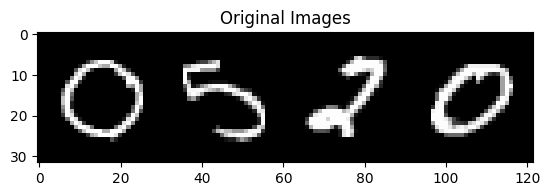

Latent space representations:
tensor([[0.0000, 0.8146, 2.2715, 0.7667, 0.2386, 0.7731, 1.1712, 0.3172, 1.3634,
         3.2306, 0.3094, 2.3666, 0.7462, 1.5423, 1.6093, 0.0000, 1.7697, 0.0000,
         0.9425, 1.9937, 0.6860, 0.0000, 0.0000, 0.0000, 1.6590, 0.0000, 0.9926,
         0.5916, 0.0000, 2.2400, 2.2815, 0.0000, 1.1143, 0.0000, 2.0786, 0.9893,
         0.0000, 0.0000, 2.4128, 2.1591, 0.7143, 0.3837, 1.9645, 1.3654, 1.7517,
         1.7941, 1.5862, 0.0000, 0.0000, 1.7230, 1.2650, 0.0097, 0.9672, 0.4128,
         0.0000, 0.0000, 1.9015, 2.3240, 0.0000, 1.0881, 0.0000, 0.0000, 1.5820,
         1.1291],
        [0.0000, 0.3320, 1.9114, 1.5350, 0.9673, 2.3116, 2.6723, 1.7960, 1.8260,
         1.9161, 0.6643, 2.3875, 0.3757, 2.0299, 1.6473, 0.0000, 2.2255, 0.0000,
         1.0264, 2.2996, 0.5350, 0.0000, 0.0000, 0.0000, 0.5460, 0.0000, 1.3068,
         1.5522, 0.0000, 1.8641, 2.6347, 0.0000, 1.1044, 0.0000, 3.4068, 1.2689,
         0.0000, 0.0000, 3.0507, 1.7016, 2.3190, 0.7482, 1.89

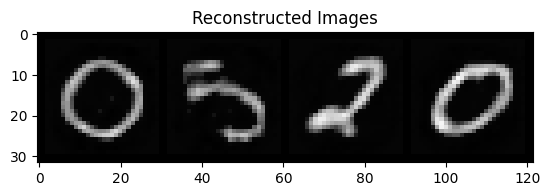

Decoded Image Representations (as vectors):
tensor([[-1.4241e-04, -3.9313e-04, -1.3408e-04,  ..., -5.1021e-04,
         -1.2632e-04, -3.7951e-04],
        [-1.3533e-04, -2.7518e-04, -3.0659e-04,  ..., -6.0659e-04,
         -1.6410e-04, -4.6241e-04],
        [-9.4761e-05, -2.1551e-04, -1.8719e-04,  ..., -5.7467e-04,
         -1.2633e-04, -2.4663e-04],
        [-8.3636e-05, -4.1866e-04, -1.8859e-04,  ..., -6.1662e-04,
         -1.8752e-04, -3.1393e-04]], device='cuda:0')


In [23]:
# Function to display a grid of images
def imshow(img, title=None):
    npimg = img.cpu().numpy()  # Move the image to CPU and convert to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Visualization of the original and reconstructed images
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)



# Flatten the images to get their original vector representations
original_vectors = images.view(-1, 28*28)[:4]
print("Original Vector Representations:")
print(original_vectors)

# Display original images
print("Original Images")
imshow(vutils.make_grid(images[:4], normalize=True), title="Original Images")

# Encoded and decoded images
with torch.no_grad():
    # Pass the original vector representations through the encoder to get latent space representations
    encoded_imgs = model.encoder(original_vectors)

    # Decode the latent space representations back into images
    decoded_imgs = model.decoder(encoded_imgs).view(-1, 1, 28, 28)

# Print latent space representations
print("Latent space representations:")
print(encoded_imgs)


# Display reconstructed images
print("Reconstructed Images")
imshow(vutils.make_grid(decoded_imgs, normalize=True), title="Reconstructed Images")

# Flatten the decoded images to print their vector representations
decoded_vectors = decoded_imgs.view(-1, 28*28)
print("Decoded Image Representations (as vectors):")
print(decoded_vectors)
